# SHAP学习笔记

# 导入数据

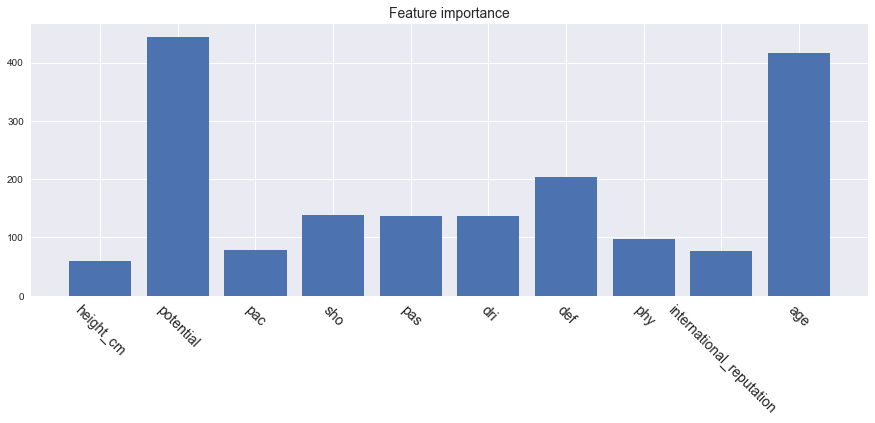

In [7]:
# 加载模块
import lightgbm as lgb
import xgboost as xgb
import catboost as cbt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('seaborn')

# 读取数据，目标变量y是球员的身价（万欧元）
data = pd.read_csv('data/train.csv')

# 获得当时球员年龄
today = pd.to_datetime('2018-01-01')
data['birth_date'] = pd.to_datetime(data['birth_date'])
data['age'] = np.round((today - data['birth_date']).apply(lambda x: x.days) / 365., 1)

# 选择特征，这里只是举例，未必是最佳组合
# 特征依次为身高（厘米）、潜力、速度、射门、传球、带球、防守、体格、国际知名度、年龄
cols = ['height_cm', 'potential', 'pac', 'sho', 'pas', 'dri', 'def', 'phy', 'international_reputation', 'age']

# 训练xgboost、LightGBM和CatBoost回归模型
# CatBoost在获取相互值上出现问题，有待解决
# model = xgb.XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=150)
model = lgb.LGBMRegressor(max_depth=4, learning_rate=0.05, n_estimators=150)
# model = cbt.CatBoostRegressor(max_depth=4, learning_rate=0.05, n_estimators=150)
model.fit(data[cols], data['y'].values)

# 获取feature importance
plt.figure(figsize=(15, 5))
plt.bar(range(len(cols)), model.feature_importances_)
plt.xticks(range(len(cols)), cols, rotation=-45, fontsize=14)
plt.title('Feature importance', fontsize=14)
plt.savefig('pictures/fea_impotance.png')

# 获取SHAP值

In [2]:
%%time
import shap

# 获取解释器explainer
explainer = shap.TreeExplainer(model)

CPU times: user 648 ms, sys: 151 ms, total: 798 ms
Wall time: 1.42 s


In [3]:
%%time
# 获取各样本shap值
shap_values = explainer.shap_values(data[cols])
shap_values.shape

CPU times: user 3.03 s, sys: 13 ms, total: 3.05 s
Wall time: 456 ms


(10441, 10)

In [4]:
%%time
# 获取各样本相互值
shap_inter_values = explainer.shap_interaction_values(data[cols])
shap_inter_values.shape

CPU times: user 23.2 s, sys: 245 ms, total: 23.4 s
Wall time: 22.5 s


(10441, 10, 10)

In [5]:
# 获取去除相互值后的数值
# 通常可以获取去除交互作用后的数据，来查看x和y的归因关系，来进行业务解释
shap_values_no_inter = []
for i in range(len(shap_values)):
    tmp = []
    for j in range(10):
        tmp.append(shap_inter_values[i][j][j])
    shap_values_no_inter.append(tmp)
shap_values_no_inter = np.array(shap_values_no_inter)

In [15]:
# 查看模型基线，该例子中为目标变量预测的均值
y_base = explainer.expected_value
data['pred'] = model.predict(data[cols])
print(y_base, data['pred'].mean())

229.2887654447139 229.28876544471544


## 查看单个样本的SHAP值

In [16]:
# 数据排30位
j = 30
player_explainer = pd.DataFrame()
player_explainer['feature'] = cols
player_explainer['feature_value'] = data[cols].iloc[j].values
player_explainer['shap_value'] = shap_values[j]
player_explainer['shap_value_no_inter'] = shap_values_no_inter[j]
player_explainer

,feature,feature_value,shap_value,shap_value_no_inter
0,height_cm,185.0,0.361800,1.723175
1,potential,86.0,1092.272074,1154.560943
2,pac,69.0,-2.426026,-3.031031
3,sho,55.0,-29.503725,-20.337102
4,pas,68.0,-17.361041,10.875089
5,dri,71.0,9.822036,15.663022
6,def,76.0,119.895244,155.959116
7,phy,84.0,66.159057,52.275836
8,international_reputation,2.0,81.185518,47.182747
9,age,20.7,-178.821703,-42.493076


In [17]:
# 我们知道一个样本中各特征SHAP值的和加上基线值应该等于该样本的预测值。
print('y_base + sum_of_shap_values: %.2f'%(y_base + player_explainer['shap_value'].sum()))
print('y_pred: %.2f'%(data['pred'].iloc[j]))

y_base + sum_of_shap_values: 1370.87
y_pred: 1370.87


In [26]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[j], data[cols].iloc[j])

## 对特征的总体分析

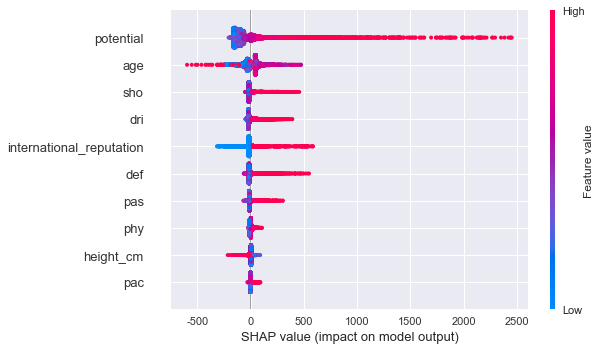

In [27]:
fig = shap.summary_plot(shap_values, data[cols], show=False)
plt.savefig('pictures/all_data_shap_1.png')

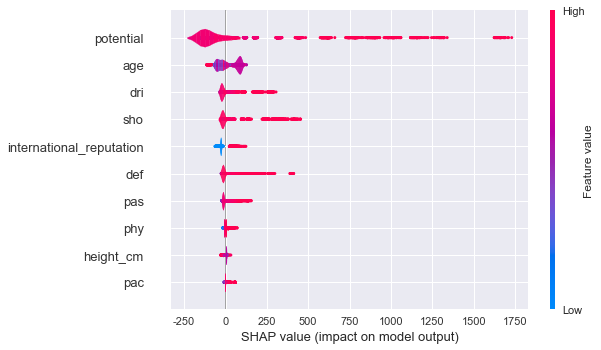

In [29]:
# 去除相互值
fig = shap.summary_plot(shap_values_no_inter, data[cols], plot_type="violin", show=False)
plt.savefig('pictures/all_data_shap_2.png')

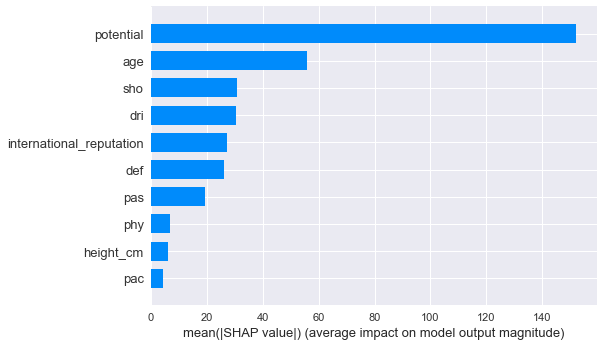

In [12]:
shap.summary_plot(shap_values, data[cols], plot_type='bar')

## 部分依赖图

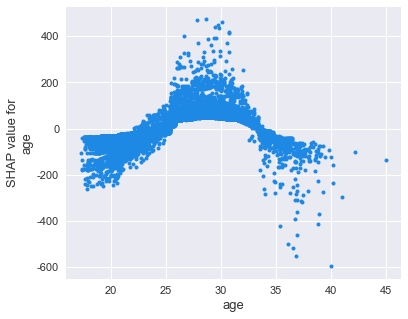

In [30]:
shap.dependence_plot('age', shap_values, data[cols], interaction_index=None, show=False)
plt.savefig('pictures/age_shap_1.png')

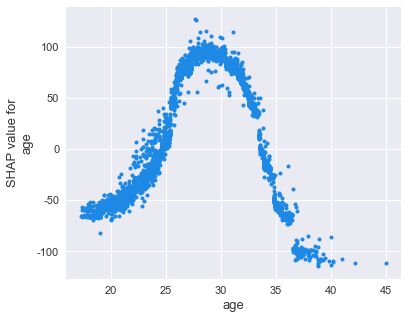

In [31]:
# 去除相互值
shap.dependence_plot('age', shap_values_no_inter, data[cols], interaction_index=None, show=False)
plt.savefig('pictures/age_shap_2.png')

## 对多个变量的交互进行分析

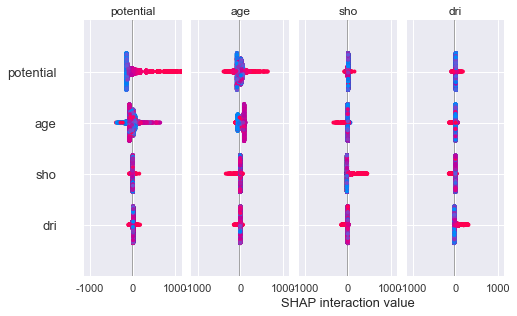

In [32]:
# 多个变量交互作用进行分析
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(data[cols])
shap.summary_plot(shap_interaction_values, data[cols], max_display=4, show=False)
plt.savefig('pictures/more_shap.png')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


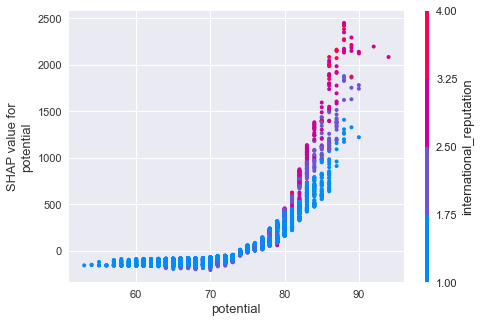

In [33]:
shap.dependence_plot('potential', shap_values, data[cols], interaction_index='international_reputation', show=False)
plt.savefig('pictures/two_shap.png')